#### Dependencies

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from math import sqrt
from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

2023-04-22 17:51:53.400566: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-22 17:51:53.448866: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-22 17:51:53.449894: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-22 17:51:54.475764: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Pre-Processing

In [2]:
df = pd.read_csv('../Dataset/Ahemdabad.csv', skiprows = 15)
df.head()

,YEAR,MO,DY,T2M_MAX,T2M,T2M_MIN,TS,RH2M,PS,T2MDEW
0,1981,1,30,32.74,23.66,16.23,24.46,39.62,100.66,8.44
1,1981,1,31,29.87,20.52,13.20,21.29,24.56,100.78,-3.58
2,1981,2,1,28.83,18.56,9.97,19.13,17.00,101.13,-7.96
3,1981,2,2,29.18,18.76,9.08,19.08,20.62,101.13,-5.92
4,1981,2,3,32.55,21.55,10.51,20.84,16.69,100.90,-6.55


In [3]:
df['YEAR'] = df.YEAR.astype(str)
df['MO'] = df.MO.astype(str)
df['DY'] = df.DY.astype(str)

df['date'] = df['DY'].str.cat(df['MO'], sep = '/')
df['dateTime'] = df['date'].str.cat(df['YEAR'], sep = '/')

df.drop(['YEAR', 'MO', 'DY','date'], axis=1, inplace=True)

In [4]:
df.set_index('dateTime', inplace = True)
df.index = pd.to_datetime(df.index, dayfirst = True)
df.head()

,T2M_MAX,T2M,T2M_MIN,TS,RH2M,PS,T2MDEW
dateTime,,,,,,,
1981-01-30,32.74,23.66,16.23,24.46,39.62,100.66,8.44
1981-01-31,29.87,20.52,13.20,21.29,24.56,100.78,-3.58
1981-02-01,28.83,18.56,9.97,19.13,17.00,101.13,-7.96
1981-02-02,29.18,18.76,9.08,19.08,20.62,101.13,-5.92
1981-02-03,32.55,21.55,10.51,20.84,16.69,100.90,-6.55


In [5]:
df.rename(columns= {'T2M_MAX':'tempMax', 'T2M':'temp', 'T2M_MIN':'tempMin', 'TS':'earthSkin','RH2M':'relativeHumidity','PS':'pressure','T2MDEW':'dew'}, inplace = True)

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
df_transformed = scaler.fit_transform(df)
print(df_transformed)
df.shape

[[0.43481325 0.41559868 0.44123783 ... 0.39283734 0.72701149 0.61860276]
 [0.33368569 0.30062248 0.33588317 ... 0.22585653 0.76149425 0.37449228]
 [0.29704017 0.2288539  0.22357441 ... 0.14203348 0.86206897 0.28554021]
 ...
 [0.56307259 0.60673746 0.63178025 ... 0.34094689 0.62356322 0.65515841]
 [0.52748414 0.60563896 0.62691238 ... 0.33052445 0.59195402 0.65779854]
 [0.47004933 0.57085317 0.64673157 ... 0.37620579 0.57471264 0.68541836]]


(15390, 7)

In [7]:
def split_sequences(data, n_steps_in, n_steps_out):
    X, Y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(data):
            break

        seq_x, seq_y = data[i:end_ix, :], data[end_ix:out_end_ix, :]
        X.append(seq_x)
        Y.append(seq_y)
    return np.array(X), np.array(Y)

In [8]:
train, test = train_test_split(df_transformed, test_size = 0.25, shuffle = False)
n_epochs = 120
n_neurons = 128
n_steps_in = 7
n_steps_out = 1
dropout_rate = 0.3
n_features = train.shape[1]
x_train, y_train, x_test, y_test = [],[],[],[]

for i in range(1, len(train)):
    x_train.append(train[i-1])
    y_train.append(train[i])

for i in range(1, len(test)):
    x_test.append(test[i-1])
    y_test.append(test[i])

X_train, Y_train = split_sequences(train, n_steps_in, n_steps_out)
X_test, Y_test = split_sequences(test, n_steps_in, n_steps_out)

X_train = X_train.reshape((X_train.shape[0], n_steps_in, n_features))
Y_train = Y_train.reshape((Y_train.shape[0], n_steps_out, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps_in, n_features))
Y_test = Y_test.reshape((Y_test.shape[0], n_steps_out, n_features))

#### Architecture

In [9]:
model = Sequential()
model.add(LSTM(n_neurons, activation='tanh', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(Dense(n_neurons, activation='tanh'))
model.add(Dropout(dropout_rate))
model.add(LSTM(n_neurons, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(n_features, activation='linear')))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=n_epochs, verbose=1)

2023-04-22 17:51:56.762436: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-22 17:51:57.443414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-22 17:51:57.446390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-22 17:51:57.448439: I tensorflow/core/com

Epoch 1/120


2023-04-22 17:51:57.919052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-22 17:51:57.921855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-22 17:51:57.925460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

361/361 [==============================] - 10s 12ms/step - loss: 0.0146 - accuracy: 0.7376
Epoch 2/120
361/361 [==============================] - 4s 12ms/step - loss: 0.0046 - accuracy: 0.8095
Epoch 3/120
361/361 [==============================] - 4s 11ms/step - loss: 0.0037 - accuracy: 0.8179
Epoch 4/120
361/361 [==============================] - 4s 11ms/step - loss: 0.0032 - accuracy: 0.8280
Epoch 5/120
361/361 [==============================] - 4s 12ms/step - loss: 0.0030 - accuracy: 0.8319
Epoch 6/120
361/361 [==============================] - 4s 12ms/step - loss: 0.0029 - accuracy: 0.8358
Epoch 7/120
361/361 [==============================] - 4s 11ms/step - loss: 0.0027 - accuracy: 0.8370
Epoch 8/120
361/361 [==============================] - 4s 11ms/step - loss: 0.0027 - accuracy: 0.8413
Epoch 9/120
361/361 [==============================] - 4s 12ms/step - loss: 0.0026 - accuracy: 0.8444
Epoch 10/120
361/361 [==============================] - 4s 12ms/step - loss: 0.0026 - accurac

In [10]:
Y_real = scaler.inverse_transform(Y_test[:,0])
Y_real[:,0]

Y_predict = []
for i in range(len(X_test)):
    X_pred = X_test[i].reshape((1, X_test[i].shape[0], n_features))
    Y_pred = model.predict(X_pred)
    Y_pred_it = scaler.inverse_transform(Y_pred[0])
    Y_predict.append(Y_pred_it)

2023-04-22 18:03:25.534614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-22 18:03:25.538276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-22 18:03:25.542178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 51ms/step


#### Prediction

In [11]:
Temp = []
for elements in Y_predict:
    Temp.append(elements[0][0])

Y_predict = np.array(Y_predict)
Y_real = np.array(Y_real)

rmse = sqrt(mean_squared_error(Y_real[:,0], Temp))
mae = mean_absolute_error(Y_real[:,0], Temp)
mape = mean_absolute_percentage_error(Y_real[:,0], Temp)

print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)

RMSE: 1.2292891836025455
MAE: 0.8841825075752875
MAPE: 0.02635791978778208


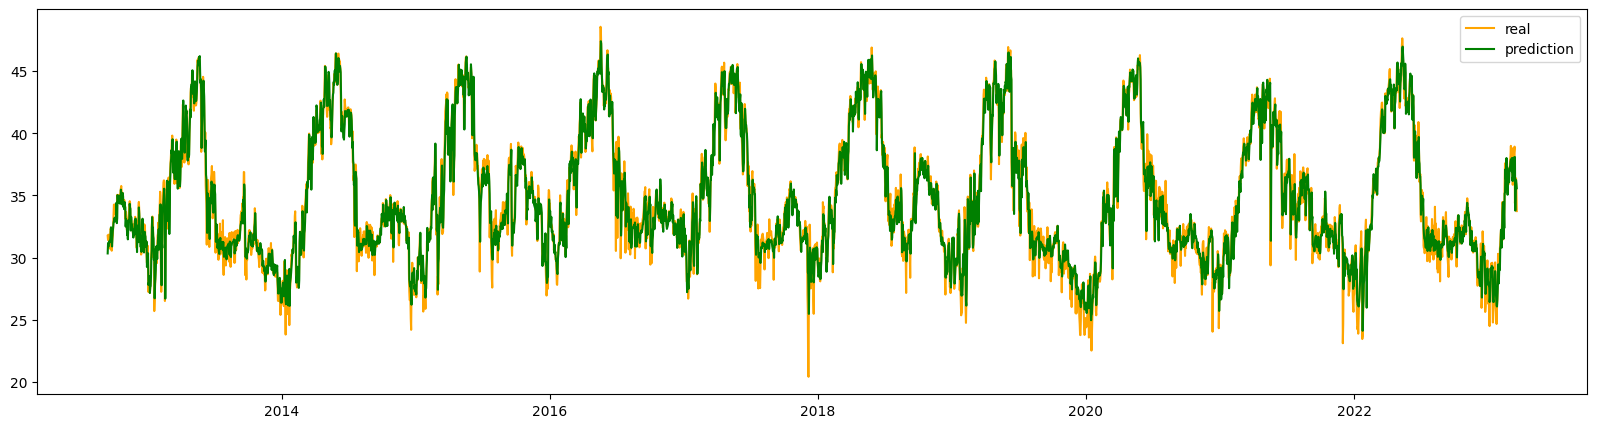

In [12]:
date = df.tail(3841).index
plt.figure(figsize=(20, 5))
plt.plot(date, Y_real[:,0], c = 'orange', label = 'real')
plt.plot(date, Temp, c = 'green', label = 'prediction')
plt.legend()